# Import required packages

- numpy
- matplotlib
- GradVI [(Link)](https://github.com/stephenslab/gradvi)
- mr.ash.pen [(Link)](https://github.com/banskt/mr-ash-pen) - provides Python wrapper for R packages `genlasso` and `mr.ash.alpha`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gradvi.tests import toy_priors, toy_data
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma
from gradvi.inference import Trendfiltering
from gradvi.models import TrendfilteringModel

from mrashpen.utils import R_trendfilter
from mrashpen.inference.mrash_wrapR import MrASHR
from mrashpen.models.mixture_gaussian import emfit

Some matplotlib parameters from `pymir` so that the package does not need to be installed

In [2]:
import matplotlib

def mpl_presentation(dpi = 300, linewidth = 2, splinewidth = 2, ticksize = 8, fontsize = 14, fontfamily = 'latex-clearsans', 
                     padding = 10, black = '#333333', splinecolor = None, textcolor = None, colors = 'banskt'):

    if textcolor is None   or textcolor == 'black':   textcolor = black
    if splinecolor is None or splinecolor == 'black': splinecolor = black

    # Size
    matplotlib.rcParams['figure.figsize'] = 8, 8
    matplotlib.rcParams['figure.dpi'] = dpi
    
    # Fonts
    matplotlib.rcParams['font.size'] = fontsize
    matplotlib.rcParams['text.color'] = textcolor
    matplotlib.rcParams['axes.titlesize'] = fontsize * 1.2
    
    matplotlib.rcParams['axes.labelsize'] = fontsize
    matplotlib.rcParams['axes.labelweight'] = 'normal'
    matplotlib.rcParams['axes.labelcolor'] = textcolor
    
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['legend.fontsize'] = fontsize
    
    # Axes
    matplotlib.rcParams['axes.titlepad'] = 20
    matplotlib.rcParams['axes.edgecolor'] = splinecolor
    matplotlib.rcParams['axes.facecolor'] = 'white'
    matplotlib.rcParams['axes.labelpad'] = 20
    matplotlib.rcParams['axes.linewidth'] = splinewidth
    
    
    # Ticks
    matplotlib.rcParams['xtick.major.size'] = ticksize
    matplotlib.rcParams['xtick.minor.size'] = 2 * ticksize / 3.0
    matplotlib.rcParams['ytick.major.size'] = ticksize
    matplotlib.rcParams['ytick.minor.size'] = 2 * ticksize / 3.0
    matplotlib.rcParams['xtick.major.pad'] = padding
    matplotlib.rcParams['xtick.minor.pad'] = padding
    matplotlib.rcParams['ytick.major.pad'] = padding
    matplotlib.rcParams['ytick.minor.pad'] = padding
    matplotlib.rcParams['xtick.major.width'] = splinewidth
    matplotlib.rcParams['xtick.minor.width'] = splinewidth
    matplotlib.rcParams['ytick.major.width'] = splinewidth
    matplotlib.rcParams['ytick.minor.width'] = splinewidth
    matplotlib.rcParams['xtick.color'] = splinecolor
    matplotlib.rcParams['ytick.color'] = splinecolor
    matplotlib.rcParams['xtick.labelcolor'] = textcolor
    matplotlib.rcParams['ytick.labelcolor'] = textcolor

    return


def mpl_plot_diag(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, ls='dotted', color='gray')
    return

# Create a toy example for trendfiltering

In [3]:
n = 256
x = np.linspace(0, 1, n)
np.random.seed(100)

degree = 1
nknots = 1
strue  = 0.2
knots  = np.linspace(0, 1, nknots+2)[1:-1]

data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "normal", seed = 100,
                        include_intercept = False)

Obtain the true coefficients and residual variance from the data.
`H` is the trendfiltering matrix and `Hinv` is the discrete difference operator matrix (denoted as $D$ by Tibshirani et al.)

In [4]:
H = gvbm.trendfiltering(n, degree)
Hinv = gvbm.trendfiltering_inverse(n, degree)
btrue  = np.dot(Hinv, data.ytrue)
s2_true = np.var(data.y - data.ytrue)

Fit a mixture of Gaussians using EM algorithm to obtain the coefficients for `ash` prior.

In [5]:
prior = toy_priors.get_ash(k = 20, sparsity = 0.9, skbase = 2.0, skfactor = 1.0)
wtrue = emfit(np.dot(Hinv, data.ytrue), prior.sk)
wmod = prior.softmax_inverse(wtrue, eps = 0)
prior.update_wmod(wmod)

Check the coefficients of the prior:

In [6]:
prior.w

array([9.88281250e-01, 1.14555179e-02, 2.38499243e-04, 2.02331759e-05,
       3.31886942e-06, 7.90731477e-07, 2.39290778e-07, 8.54906119e-08,
       3.45006106e-08, 1.52824981e-08, 7.28581200e-09, 3.68608733e-09,
       1.95855030e-09, 1.08428972e-09, 6.21613395e-10, 3.67227891e-10,
       2.22678179e-10, 1.38147823e-10, 8.74525942e-11, 5.63624508e-11])

Plot the observed data and the oracle.

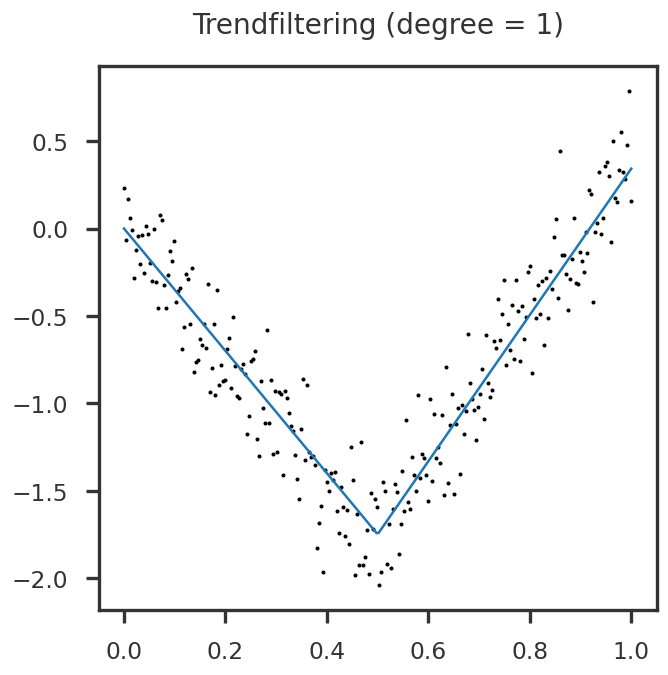

In [7]:
mpl_presentation(dpi = 120, textcolor = None)

fig = plt.figure(figsize = (6, 6))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

plt.show()

# Fitting the model

### mr.ash.alpha -- initialize from oracle

In [8]:
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(H, data.y, prior.sk,
            binit = np.dot(Hinv, data.ytrue), winit = wtrue, s2init = s2_true,
            update_pi = False, update_sigma2 = False)

mrash_ypred = np.dot(H, mrash_r.coef) + mrash_r.intercept
oracle_elbo = mrash_r.elbo_path[-1]

Mr.ASH terminated at iteration 24.


### Genlasso (using 5-fold crossvalidation)

In [18]:
y_genlasso, fit_genlasso = R_trendfilter.fit(data.y, order = degree)

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 



### GradVI (L-BFGS) -- initialize from moving average

The default optimization method is L-BFGS. See below how to change the optimzation method.

In [9]:
y_ma = gvma.moving_average(data.y)

In [10]:
gv1 = Trendfiltering(optimize_s = False, optimize_w = False, standardize_basis = False, standardize = False, maxiter = 10000)
gv1.fit(data.y, degree, prior, s2_init = s2_true, y_init = y_ma)

In [11]:
print (f"Number of steps performed in L-BFGS: {gv1.niter}, Success = {gv1.success}")
print (gv1.fitobj.message)

Number of steps performed in L-BFGS: 5601, Success = True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


### GradVI (Newton-CG) -- initialize from moving average

The Hessian function is poorly written function with lots of global variables (e.g. `H`, `data`, `s2_true`, `prior`, `degree`). Ideally, I need the `TrendfilteringModel` from the `Trendfiltering` class to calculate the Hessian at every step during the optimization. In the main program logic, the `TrendfilteringModel` is privately available at every iteration but there is no easy way to access the same from outside. Here, I am hacking the code to feed the Hessian function from outside and therefore, I am recreating the `TrendfilteringModel` using the optimization parameters and the options which are specific to the optimizer. Any change in the `Trendfiltering` optimizer must require corresponding changes in the `TrendfilteringModel` (for example, `standardize_basis`, `scale_basis`, `tfbasis_matrix`, etc.).

Other `scipy.optimize.minimize` methods can be used by changing the `method = 'newton-cg'` in `Trendfiltering`, and options specific to the minimizer can be passed via `options = {key: value}`.

In [12]:
def hessian_func(params):
    tfm = TrendfilteringModel(H, data.y, params, s2_true, prior, objtype = 'reparametrize', 
                             tf_degree = degree, tfbasis_matrix = H, 
                             tfbasis_scale_factors = (None, None), 
                             standardize_basis = False,
                             scale_basis = False)
    
    nm = tfm.get_normal_means_model()
    Mb, Mb_bgrad, Mb_wgrad, Mb_sj2grad, Mb_bgrad2 = nm.shrinkage_operator(jac = True, hess = True)
    lj, l_bgrad,  l_wgrad,  l_sj2grad, l_bgrad2  = nm.penalty_operator(jac = True, hess = True)

    r    = tfm._y - tfm.Xdotv(Mb)
    rTX  = tfm.XTdotv(r)

    hess = np.dot(tfm._X.T, tfm._X) * np.outer(Mb_bgrad, Mb_bgrad) / tfm._s2
    hess[np.diag_indices_from(hess)] += l_bgrad2 - (rTX * Mb_bgrad2 / tfm._s2)
    hess[np.diag_indices_from(hess)][np.where(np.diag(hess) == 0)] = 1e-2
    return hess



gv2 = Trendfiltering(maxiter = 10000, standardize_basis = False, standardize = False,
                     optimize_s = False, optimize_w = False,
                     method = 'newton-cg', hessian_callable = hessian_func, options = {'xtol': 1e-12})
gv2.fit(data.y, degree, prior, y_init = y_ma, s2_init = s2_true)

In [13]:
print (f"Number of steps performed in Newton-CG: {gv2.niter}, Success = {gv2.success}")
print (gv2.fitobj.message)

Number of steps performed in Newton-CG: 1000, Success = True
Optimization terminated successfully.


In [14]:
final_hessian_newtoncg = hessian_func(gv2.fitobj.x)
final_gradient_newtoncg = gv2.grad

### Save gradient and Hessian for Peter

In [15]:
# np.savetxt('final_gradient_newtoncg.csv', final_gradient_newtoncg, delimiter = ",")
# np.savetxt("final_hessian_newtoncg.csv", final_hessian_newtoncg, delimiter=",")

# Plot

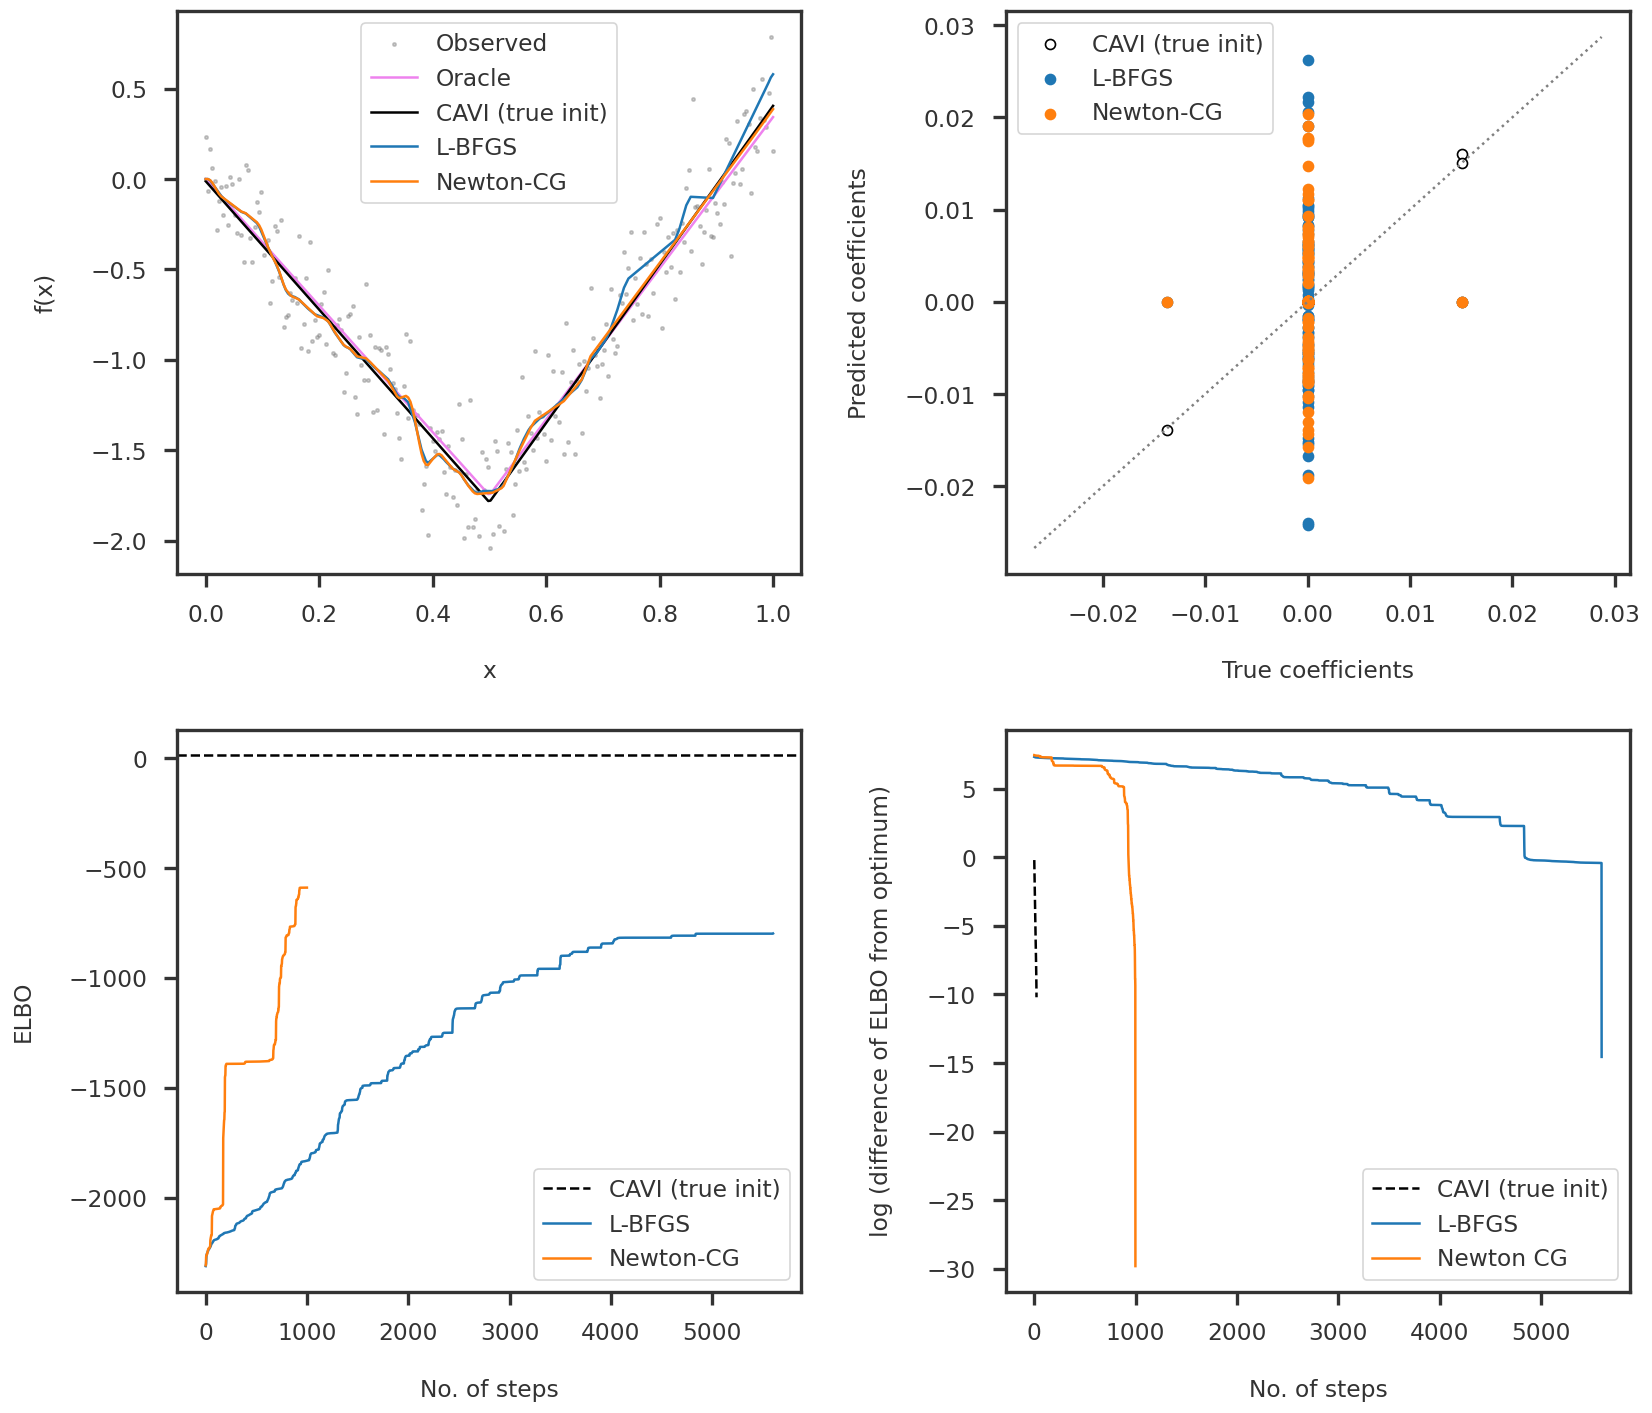

In [16]:
mpl_presentation(dpi = 120)

fig = plt.figure(figsize = (14, 12))
ax  = [fig.add_subplot(2,2,i+1) for i in range(4)]

ax[0].scatter(data.x, data.y, color = 'grey', label = 'Observed', alpha = 0.4, s = 4)
ax[0].plot(data.x, data.ytrue, color = 'violet', label = 'Oracle')
ax[0].plot(data.x, mrash_ypred, color = 'black', label = 'CAVI (true init)')
ax[0].plot(data.x, gv1.ypred, label = 'L-BFGS')
ax[0].plot(data.x, gv2.ypred, label = 'Newton-CG')
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_ylabel('f(x)')

btrue = np.dot(Hinv, data.ytrue)
ax[1].scatter(btrue, mrash_r.coef, label = 'CAVI (true init)', color = 'black', facecolor = 'white')
ax[1].scatter(btrue, gv1.coef, label = 'L-BFGS')
ax[1].scatter(btrue, gv2.coef, label = 'Newton-CG')
ax[1].legend()
ax[1].set_xlabel("True coefficients")
ax[1].set_ylabel("Predicted coefficients")
mpl_plot_diag(ax[1])

if mrash_r.niter > 0.2 * gv1.niter:
    ax[2].plot(np.arange(mrash_r.niter), - mrash_r.elbo_path, 
          color = 'black', ls = 'dashed', label = 'CAVI (true init)')
else:
    ax[2].axhline(y = - mrash_r.elbo_path[-1], color = 'black', ls = 'dashed', label = 'CAVI (true init)')
ax[2].plot(np.arange(gv1.niter), - gv1.elbo_path, label = 'L-BFGS')
ax[2].plot(np.arange(gv2.niter), - gv2.elbo_path, label = 'Newton-CG')
ax[2].set_xlabel("No. of steps")
ax[2].set_ylabel("ELBO")
ax[2].legend()


ax[3].plot(np.arange(mrash_r.niter - 1), 
           np.log(mrash_r.elbo_path[:-1] - mrash_r.elbo_path[-1]), 
           label = 'CAVI (true init)', color = 'black', ls = 'dashed')
ax[3].plot(np.arange(gv1.niter - 1), np.log(gv1.obj_path[:-1] - gv1.obj_path[-1]), label = 'L-BFGS')
ax[3].plot(np.arange(gv2.niter - 1), np.log(gv2.obj_path[:-1] - gv2.obj_path[-1]), label = 'Newton CG')
ax[3].legend()
ax[3].set_ylabel("log (difference of ELBO from optimum)")
ax[3].set_xlabel("No. of steps")


fig.tight_layout(w_pad = 2.0, h_pad = 2.0)

#plt.savefig('newton_converge_complete.png', bbox_inches = 'tight')
plt.show()

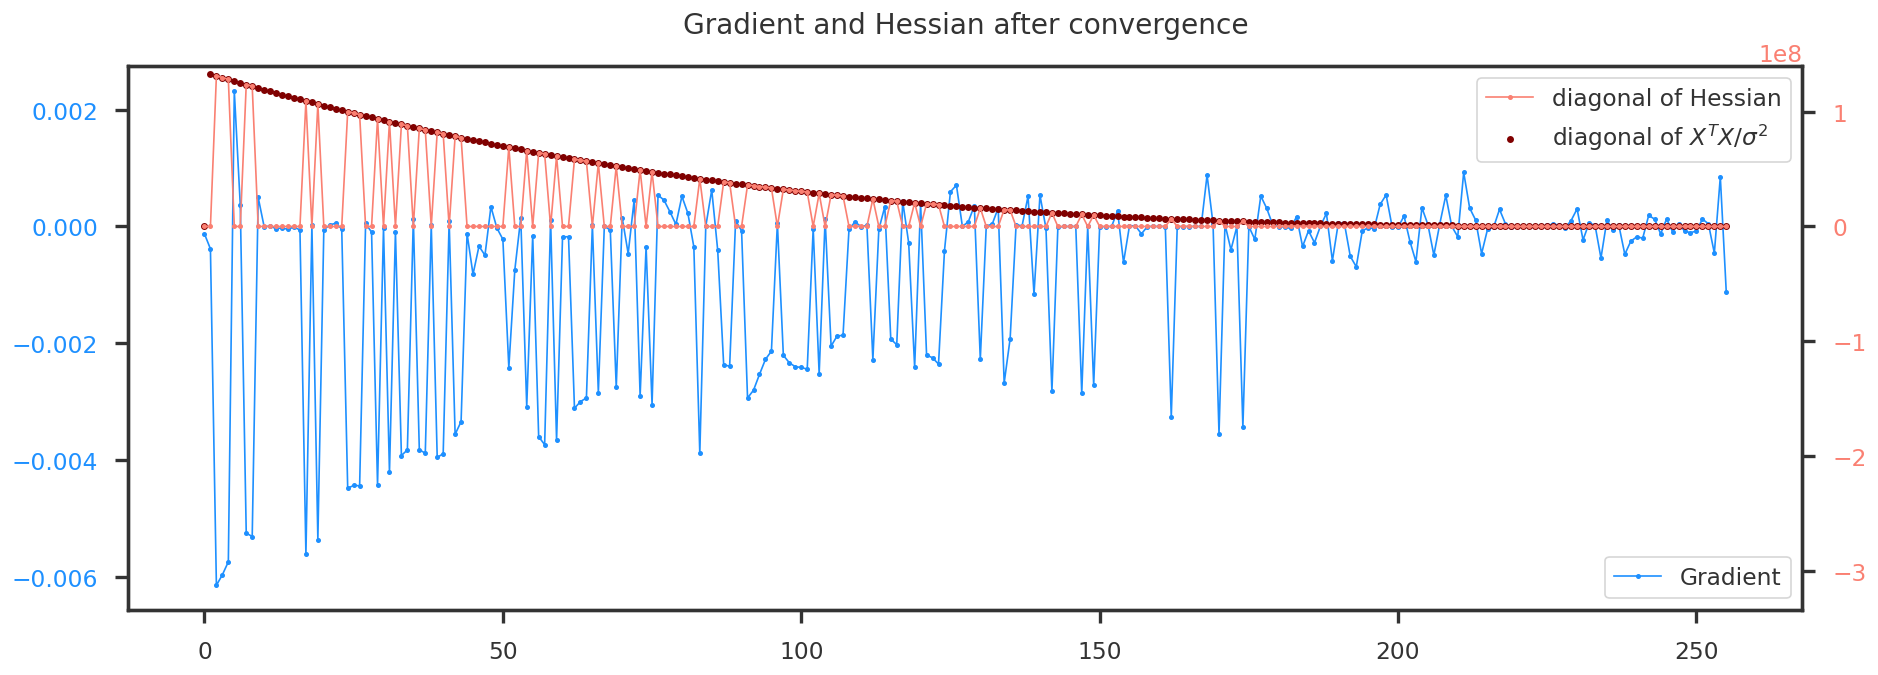

In [17]:
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

color1 = 'dodgerblue'
color2 = 'salmon'

ax1.plot(np.arange(n), final_gradient_newtoncg, lw = 1, label = 'Gradient', marker = 'o', markersize = 2, color = color1)
ax2.plot(np.arange(n), np.diag(final_hessian_newtoncg), lw = 1, label = 'diagonal of Hessian', marker = 'o', markersize = 2, color = color2)
ax2.scatter(np.arange(n), np.diag(np.dot(data.H.T, data.H))  / s2_true, lw = 1, label = r'diagonal of $X^{T}X / \sigma^2$', s = 10, color = 'maroon')


ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

ax1.legend(loc = 'lower right')
ax2.legend(loc = 'upper right')

# force axes to have zero at the same level
y1min, y1max = ax1.get_ylim() ; y1ticks = ax1.get_yticks()
y2min, y2max = ax2.get_ylim() ; y2ticks = ax2.get_yticks()
y2min = (y1min / y1max) * y2max
ax1.set_ylim(y1min, y1max)
ax2.set_ylim(y2min, y2max)

plt.title("Gradient and Hessian after convergence", pad = 20)

#plt.savefig('newton_converge_complete_gradient_check.png', bbox_inches = 'tight')

plt.show()